In [ ]:
# LO CIRCUITS
# can always get a unitary matrix from a LO circuit in Perceval
# we can convert a matrix into a ZW circuit in optyx
# the opposite way is how we evaluate LO circuits in perceval

In [ ]:
# MORE GENERAL CIRCUITS
#

In [20]:
import numpy as np

import perceval as pcvl
from perceval import catalog

In [76]:
p = pcvl.Processor("SLOS", 6)
p.add(0, catalog["postprocessed cnot"].build_processor())
p.add(0, pcvl.BS.H())
p.add(2, pcvl.Detector.pnr())
p.add(3, pcvl.Detector.pnr())
p.add(0, pcvl.Detector.pnr())
p.add(1, pcvl.Detector.pnr())

In [77]:
# 2 measured modes
# offset = 0 means that there is 0 empty modes between the measured modes and the circuit
# the default circuit is an empty circuit
ff_X = pcvl.FFCircuitProvider(2, 0, pcvl.Circuit(2))

# Now if we measure a logical state |1>, we need to perform a permutation of the modes
ff_X.add_configuration([0, 1], pcvl.PERM([1, 0]))

p.add(2, ff_X);

In [78]:
phi = pcvl.P("phi")
# Like Circuits and Processors, we can chain the `add` methods
ff_Z = pcvl.FFConfigurator(2, 3, pcvl.PS(phi), {"phi": 0}).add_configuration([0, 1], {"phi": np.pi})

p.add(0, ff_Z);

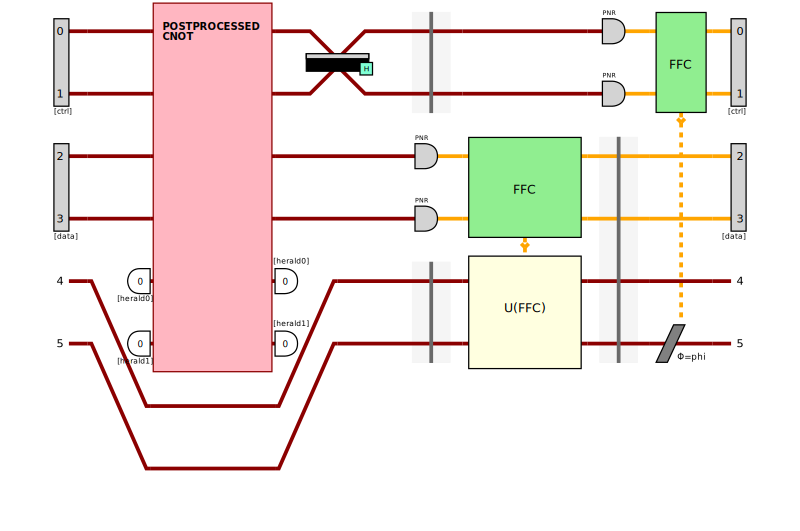

In [79]:
pcvl.pdisplay(p)

In [80]:
p.components

[[[4, 5, 6, 7],
 [[0, 1, 2, 3, 4, 5],
 [[4, 5, 6, 7],
 ((0, 1), <perceval.components.unitary_components.BS at 0x742c754fc2b0>),
 ((0, 1, 2, 3, 4, 5),
  <perceval.components.unitary_components.Barrier at 0x742c754fce80>),
 ((0, 1), <perceval.components.unitary_components.Barrier at 0x742c754fc670>),
 ((2,), <perceval.components.detector.Detector at 0x742c754fc8b0>),
 ((3,), <perceval.components.detector.Detector at 0x742c754fd7e0>),
 ((4, 5), <perceval.components.unitary_components.Barrier at 0x742c754fd060>),
 ((2, 3),
  <perceval.components.feed_forward_configurator.FFCircuitProvider at 0x742c754fcc10>),
 ((0, 1, 2, 3, 4, 5),
  <perceval.components.unitary_components.Barrier at 0x742c754fe2f0>),
 ((0,), <perceval.components.detector.Detector at 0x742c754fe5f0>),
 ((1,), <perceval.components.detector.Detector at 0x742c754fc2e0>),
 ((2, 3, 4, 5),
  <perceval.components.unitary_components.Barrier at 0x742c7557bbe0>),
 ((0, 1),
  <perceval.components.feed_forward_configurator.FFConfigurat

In [87]:
np.array(p.components[9][1].default_circuit.U, dtype=np.complex128)

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [74]:
from optyx import photonic

In [ ]:
from optyx.classical import SubN, Digit

(Digit(2) @ Digit(6) >> SubN()).eval()

EvalResult(_tensor=tensor.Box[complex128]('Result', Dim(1), Dim(3), data=array([0.+0.j, 0.+0.j, 0.+0.j])), output_types=optyx.core.channel.Ty(optyx.core.channel.Ob('mode')), state_type=<StateType.DM: 'dm'>)

In [ ]:
from optyx._utils import matrix_to_zw
from optyx import Channel, mode
from optyx.classical import ClassicalFunction
from perceval.components.detector import DetectionType

n_modes = p.circuit_size
circuit = photonic.Id(n_modes)
for c in p.components:
    component = c[1]
    wires = c[0]
    left = circuit.cod[:min(wires)]
    right = circuit.cod[max(wires)+1:]
    if isinstance(component, pcvl.Detector):
        if c.type == DetectionType.PNR:
            circuit_component = photonic.NumberResolvingMeasurement(len(wires))
        elif c.type == DetectionType.Threshold:
            circuit_component = photonic.PhotonThresholdMeasurement(len(wires))
        else:
            raise ValueError(f"Unsupported perceval detector type: {c.type}")
        box = circuit_component
    elif isinstance(component, pcvl.FFConfigurator):
        default_action = component.default_circuit.U
        function_boxes = []
        action_boxes = []
        for state, action_circuit in component._map.items():
            def f(x):
                if all(s == a for s, a in zip(list(state), x)):
                    return [1]
                else:
                    return [0]
            function_boxes.append(ClassicalFunction(f, mode*len(state), mode))
            action_boxes.append(
                matrix_to_zw(
                    np.array(
                        action_circuit.U,
                        dtype=np.complex128
                    )
                )
            )

        # need a wire permutation to get the classical measurement output
        # to the right place in the circuit (next to the actioned modes)

        # you can chain each configuration
        # copy the classical data for each config (using a spider)
        # and use it for the next config

        # need to find a way to get a specific multi mode configuration to a simple 1/0
            # classical function? n->1 if the state is as in the configuration, 0 otherwise
    elif hasattr(component, 'U'):
        circuit_component = matrix_to_zw(np.array(component.U, dtype=np.complex128))
        box = Channel(
            name=c[1].name,
            kraus=circuit_component
        )
    else:
        raise ValueError(f"Unsupported perceval component type: {type(component)}")
    circuit_layer = left @ box @ right
    circuit >>= circuit_layer

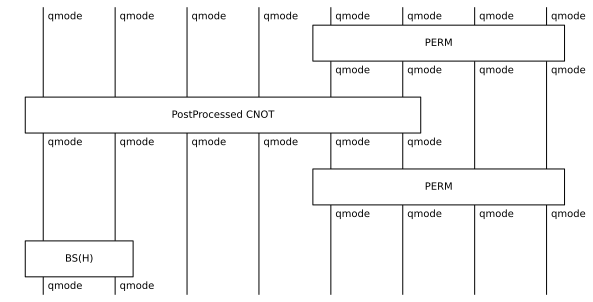

In [58]:
circuit.draw()

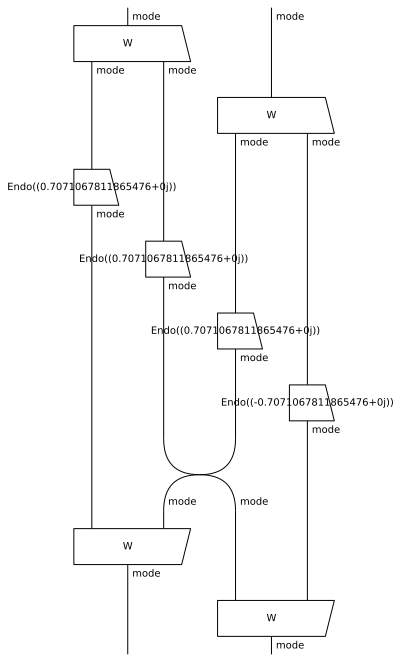

In [51]:
circuit_kraus.draw()

In [31]:
np.array(c[1].U, dtype=np.complex128)

array([[ 0.57735027+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j,  0.81649658+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.57735027+0.j,  0.57735027+0.j,
         0.57735027+0.j,  0.        +0.j,  0.        +0.j],
       [ 0.        +0.j,  0.57735027+0.j,  0.57735027+0.j,
         0.        +0.j,  0.        +0.j,  0.57735027+0.j],
       [ 0.        +0.j,  0.57735027+0.j,  0.        +0.j,
         0.57735027+0.j,  0.        +0.j, -0.57735027+0.j],
       [ 0.81649658+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j, -0.57735027+0.j,  0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.57735027+0.j,
        -0.57735027+0.j,  0.        +0.j, -0.57735027+0.j]])

In [28]:
np.array(c[1].U)

array([[0.577350269189626, 0, 0, 0, 0.816496580927726, 0],
       [0, -0.577350269189626, 0.577350269189626, 0.577350269189626, 0,
        0],
       [0, 0.577350269189626, 0.577350269189626, 0, 0, 0.577350269189626],
       [0, 0.577350269189626, 0, 0.577350269189626, 0,
        -0.577350269189626],
       [0.816496580927726, 0, 0, 0, -0.577350269189626, 0],
       [0, 0, 0.577350269189626, -0.577350269189626, 0,
        -0.577350269189626]], dtype=object)

In [9]:
p.components[0]

[[4, 5, 6, 7], <perceval.components.unitary_components.PERM at 0x71ae703c2e90>]

In [12]:
np.array(p.components[0][1].U)

array([[0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]])

In [15]:
p.components[0][1].name

'PERM'

In [ ]:
# each component has a matrix, therefore can be easily converted to a ZW circuit